<a href="https://colab.research.google.com/github/AnshCoderRepo/HybridRMS/blob/main/HybridRMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162994 sha256=9232ec3adc801576cb39cff9f26c52975bb9900539221c0eb9ab5686f8030757
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import tensorflow as tf
import pandas as pd
import surprise

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel #You can use the linear kernel function when you want to compute the similarity between samples based on their feature representations. It's commonly used in machine learning tasks such as clustering, classification, and dimensionality reduction.
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader#Typically, you first create a Reader object by specifying the parameters of your dataset, such as the rating scale and delimiter. Then, you use the Dataset class to load the data using the load_from_file or load_from_df methods, passing the Reader object as an argument.
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
import functools
import ipywidgets as widgets
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataframe=pd.read_csv("/content/drive/MyDrive/movies_final.csv")
dataframe.shape

(722463, 20)

In [ ]:
# deleting all the duplicated dataframe rows
dataframe.isnull().sum()
dataframe.drop_duplicates(inplace=True)

In [ ]:
# we ignore repeated movies
dataframe[['title','release_date']].duplicated().sum()
dataframe.drop_duplicates(subset=['title','release_date'],inplace=True)

In [ ]:
# considering genres and overviews as the key predict, we fill up the null value
dataframe.fillna('',inplace=True)
null_value=dataframe[(dataframe['genres']=='') & (dataframe['overview']=='')].index
dataframe.drop(null_value,inplace=True)

dataframe.isnull().sum() # we obtain no duplication

id                      0
title                   0
genres                  0
original_language       0
overview                0
popularity              0
production_companies    0
release_date            0
budget                  0
revenue                 0
runtime                 0
status                  0
tagline                 0
vote_average            0
vote_count              0
credits                 0
keywords                0
poster_path             0
backdrop_path           0
recommendations         0
dtype: int64

Text(0.5, 1.0, 'Popular Movies')

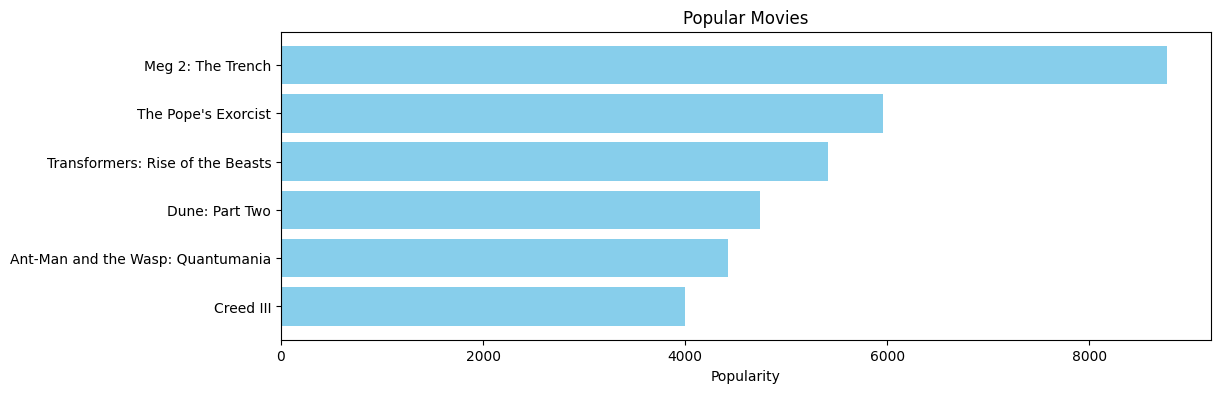

In [ ]:
# Bar graph, Popularity vs Title
pop= dataframe.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Text(0.5, 1.0, 'vote count of few movies')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65326 (\N{FULLWIDTH LATIN CAPITAL LETTER N}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65317 (\N{FULLWIDTH LATIN CAPITAL LETTER E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65335 (\N{FULLWIDTH LATIN CAPITAL LETTER W}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) miss

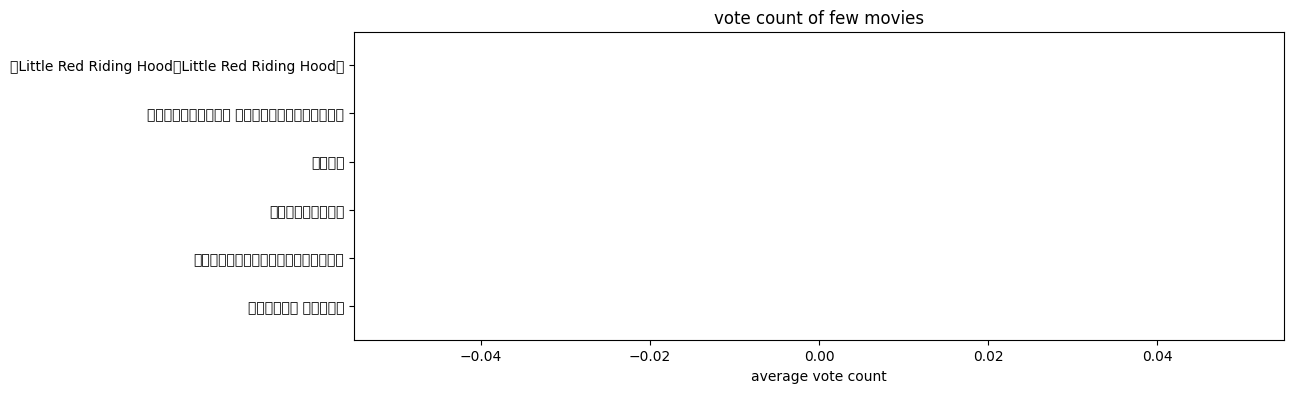

In [ ]:
#bar graph , title vs vote_average
pop= dataframe.sort_values('title', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6),pop['vote_average'].head(6), align='center',color='green')
plt.gca().invert_yaxis()
plt.xlabel("average vote count")
plt.title("vote count of few movies")

# PREPROCESSING¶

**Data Preprocessing is one of the important task to perform in any machine learning or deep learning algorithm. Here in this section we preprocess the data by applying parameters to vote_mean and vote_percentile. We then calculate the weighted_average( explained below ) and create a new column "Score". Further we consider features to produce precise predictions.**

In [ ]:
vote_mean=dataframe['vote_average'].mean() #calculating mean value of the voting for a particular movie
vote_percentile=dataframe['vote_count'].quantile(0.9) # calculating the percentile of vote obtained
vote_mean,vote_percentile

(2.446661150801905, 11.0)

**We can't consider movies which high rating with less people voting for it, so according to IMDb Weighted Average function the right approach is to consider the percentile and mean of votes. The equaltion of this is show below: (v/(v+vote_percentile)R)+(vote_percentile/(vote_percentile+v)vote_mean)**

In [ ]:
def weighted_average(X,vote_mean=vote_mean,vote_percentile=vote_percentile):
    R=X['vote_average']
    v=X['vote_count']
    return round((v/(v+vote_percentile)*R)+(vote_percentile/(vote_percentile+v)*vote_mean))

In [ ]:
# consider movies having vote_count more that 20
dataframe = dataframe[dataframe.vote_count>=20].reset_index()
dataframe.shape

(45161, 21)

In [ ]:
# adding column "score" into the dataframe
dataframe['score']=dataframe.apply(weighted_average,axis=1)
dataframe['score']

0        7
1        7
2        7
3        8
4        6
        ..
45156    3
45157    7
45158    4
45159    3
45160    4
Name: score, Length: 45161, dtype: int64

In [ ]:
# In here we remove noise ('-') from each column in the dataframe.
# we do this for genres,overview,credits,keywords
dataframe['genres']=dataframe['genres'].apply(lambda i:' '.join(i.split('-')))
dataframe['overview']=dataframe['overview'].apply(lambda i:' '.join(i.split('-')))
dataframe['credits']=dataframe['credits'].apply(lambda i:' '.join(i.split('-')[:5]))
dataframe['keywords']=dataframe['keywords'].apply(lambda i:' '.join(i.split('-')))

In [ ]:
# We consider only genres,overview,credits,keywords as our features
dataframe['features']=dataframe['genres']+' '+ dataframe['overview']+' ' + dataframe['credits']+' '+dataframe['keywords']
dataframe['features'][3]

'Science Fiction Adventure Follow the mythic journey of Paul Atreides as he unites with Chani and the Fremen while on a path of revenge against the conspirators who destroyed his family. Facing a choice between the love of his life and the fate of the known universe Paul endeavors to prevent a terrible future only he can foresee. Timothée Chalamet Zendaya Rebecca Ferguson Javier Bardem Josh Brolin epic based on novel or book fight sandstorm sand spice chosen one sequel distant future creature planet desert destiny giant worm space opera sand dune messiah vengeance giant creature power violence dune part two'

In [ ]:
# remove noise
dataframe['features']=dataframe['features'].str.replace('[^\w\s]','')
dataframe['features'][3]

'Science Fiction Adventure Follow the mythic journey of Paul Atreides as he unites with Chani and the Fremen while on a path of revenge against the conspirators who destroyed his family. Facing a choice between the love of his life and the fate of the known universe Paul endeavors to prevent a terrible future only he can foresee. Timothée Chalamet Zendaya Rebecca Ferguson Javier Bardem Josh Brolin epic based on novel or book fight sandstorm sand spice chosen one sequel distant future creature planet desert destiny giant worm space opera sand dune messiah vengeance giant creature power violence dune part two'

# CONTENT BASED FILTERING

**Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.The approach can be used in various domains, such as movies, music, books, and products, where items have well-defined attributes.**

In [ ]:
# using tfidf vectorizer to vectorize the feature value.
# This converts english words into numerical values.
tfidf=TfidfVectorizer(stop_words='english')
tfidf_vector=tfidf.fit_transform(dataframe['features'])

print(tfidf_vector)

  (0, 49752)	0.1761813317656268
  (0, 85796)	0.11774135401198348
  (0, 12471)	0.09063895965548138
  (0, 68472)	0.09285391100620793
  (0, 8836)	0.0751959282885757
  (0, 62134)	0.23625852094279742
  (0, 72851)	0.23303015389871595
  (0, 85866)	0.16075439504447667
  (0, 15405)	0.22763524807917007
  (0, 89578)	0.16944292257517582
  (0, 87485)	0.256743505299146
  (0, 48708)	0.1868634512913653
  (0, 104692)	0.16000582628632454
  (0, 90901)	0.19352204251736488
  (0, 48153)	0.12145112601476366
  (0, 92829)	0.1292590414308563
  (0, 9036)	0.11441373740474241
  (0, 90657)	0.17561243870702206
  (0, 42941)	0.0980843478957566
  (0, 34640)	0.12258438357149282
  (0, 63660)	0.11725856345532785
  (0, 95698)	0.1423789957518056
  (0, 69777)	0.14867950704780541
  (0, 63328)	0.17078642594608096
  (0, 59011)	0.18391654073764543
  :	:
  (45160, 26792)	0.11544584921329283
  (45160, 81130)	0.07515384533827582
  (45160, 89724)	0.10832377148373513
  (45160, 34171)	0.11801726158542905
  (45160, 86674)	0.14306788228

**Formula used in Content-Based Filtering: To calculate the similarity between items, the system typically employs a similarity metric such as cosine similarity or Euclidean distance. Let's consider cosine similarity for item A and item B:

Cosine Similarity between items A and B: Cosine_Similarity(A, B) = (A ⋅ B) / (||A|| * ||B||)**

# **COLABORATIVE FILTERING**

**Collaborative filtering is a recommendation technique that identifies patterns in user-item interactions and leverages the behavior of multiple users to make personalized recommendations. It focuses on finding similarities between users or items based on their historical interactions to suggest items that users with similar tastes have enjoyed.We use surprise module for this purpose**

**SVD stands for Singular Value Decomposition, and it is a mathematical technique used in various applications, including recommendation systems, image processing, data compression, and more. In**

In [ ]:
reader=Reader(rating_scale=(1,10))#  rating ranging from 1 to 10
data=Dataset.load_from_df(dataframe[['id','title','score']],reader)
trainset, testset= train_test_split(data,test_size=0.2)
colab_fit=SVD()
cross_validate(colab_fit,data,measures=['RMSE','MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0222  1.0118  1.0192  1.0217  1.0164  1.0183  0.0038  
MAE (testset)     0.8352  0.8240  0.8321  0.8342  0.8292  0.8309  0.0041  
Fit time          1.73    1.64    1.20    0.97    1.09    1.32    0.30    
Test time         0.12    0.11    0.07    0.06    0.07    0.09    0.02    


{'test_rmse': array([1.02220244, 1.01184096, 1.01918819, 1.021682  , 1.01643756]),
 'test_mae': array([0.83518285, 0.82395305, 0.83212702, 0.83420941, 0.82917836]),
 'fit_time': (1.7269811630249023,
  1.636613368988037,
  1.2045791149139404,
  0.9677820205688477,
  1.0864248275756836),
 'test_time': (0.12092804908752441,
  0.11200308799743652,
  0.07118582725524902,
  0.061055660247802734,
  0.07036375999450684)}

In [ ]:
colab_fit.fit(trainset)

# Hybrid Model

**This is an unique approach where the profit of content based filtering and colaborative filtering are summed up into single model called hybrid model. This model takes in user_id and title of the movie and predict the movie recommended by both content and colaborative filtering.**

In [ ]:
@functools.lru_cache(maxsize=None)
def hybrid_recommendation(user_id, title, n=5):
    movie_index = dataframe[dataframe['title'] == title].index[0]

    # Content-based filtering
    content_scores = list(enumerate(linear_kernel(tfidf_vector, tfidf_vector[movie_index])))
    content_scores = sorted(content_scores, key=lambda x: x[1], reverse=True)
    content_based_rec = [dataframe['title'].iloc[idx] for idx, _ in content_scores[2:n+1]]

    # Collaborative-based filtering
    user_movie_titles = dataframe[dataframe['id'] == user_id]['title'].values
    user_movie_rec = [title for title in dataframe['title'].unique() if title not in user_movie_titles]
    collaborative_rec = [title for title in user_movie_rec if colab_fit.predict(user_id, title).est > 3.5][:n]

    # Hybrid filtering
    recommendations = content_based_rec + collaborative_rec

    # Remove the movie that remains constant in all recommendations
    constant_movie = 'The Constant Movie'  # Replace with the actual movie title
    recommendations = [movie for movie in recommendations if movie != constant_movie]

    return recommendations[:n]  # Return only the top n recommendations


import random
import ipywidgets as widgets

# Get unique movie titles from the dataset
movie_titles = dataframe['title'].unique()

# Create a dropdown widget for selecting a movie
movie_dropdown = widgets.Dropdown(options=movie_titles, description='Select Movie')

# Function to generate recommendations when a movie is selected
def generate_recommendations(movie_title):
    # Get a random user ID from the dataset
    user_id = random.choice(dataframe['id'].unique())

    # Generate recommendations for the selected movie and random user
    recommendation = hybrid_recommendation(user_id, movie_title, n=8)

    # Print the recommendations
    print("Hybrid Recommendation for Random User and Selected Movie:")
    for idx, movie in enumerate(recommendation, start=1):
        print(f"{idx}. {movie}")

# Call the generate_recommendations function when a movie is selected
widgets.interact(generate_recommendations, movie_title=movie_dropdown)


interactive(children=(Dropdown(description='Select Movie', options=('Meg 2: The Trench', "The Pope's Exorcist"…

<function __main__.generate_recommendations(movie_title)>

# New SectionUSER INTERFACE USING IPY WIDGETS

**I made an attempt to put this in a small user interface model ie ipywidgets . This frame has two buttons one for movie selection and other for recommendations. On passing the title the model makes best recommendations possible**

In [ ]:
def display_recommendation(btn):
  user_id=502356
  movie_title=random_movie
  n_recommendations=6

  # Get the top N Hybrid Recommendation
  hybrid_rec=hybrid_recommendation(user_id,movie_title,n=n_recommendations)
  # display the recommendation in the output frame
  recommendations_output.clear_output()
  with recommendations_output:
    print("Movie  Recommendation :")
    for idx, movie  in enumerate(hybrid_rec, start=1):
      print(f"{idx}. {movie}")

# Buttom to select a random movie image
random_movie_button=widgets.Button(description="Select Random Movie")
# Buttom for movie Recommendation
recommend_button=widgets.Button(description="Give Recommendation")


# Output frame to display recommendation
recommendations_output=widgets.Output()

def random_movie_button_click(btn):
  global random_movie
  movie_titles=dataframe['title'].unique()
  random_movie=np.random.choice(movie_titles)
  base_domain='https://image.tmdb.org/t/p/w500'
  image_links=base_domain+dataframe.loc[dataframe['title']==random_movie,'poster_path'].iloc[0]
  image_widget=Image(url=image_links, width=200, height=300)
  display(image_widget)
random_movie_button.on_click(random_movie_button_click)
recommend_button.on_click(display_recommendation)
intro_text=widgets.HTML("<p> Lets See What's Going on </h2>")
random_movie_text=widgets.HTML("<p> Let see what is the recommendation")

display(intro_text)
display(random_movie_text)
display(random_movie_button)
display(recommendations_output)
display(recommend_button)

HTML(value="<p> Lets See What's Going on </h2>")

HTML(value='<p> Let see what is the recommendation')

Button(description='Select Random Movie', style=ButtonStyle())

Output()

Button(description='Give Recommendation', style=ButtonStyle())

In [ ]:
def display_recommendations(btn):
    user_id = 502356
    movie_title = random_movie
    n_recommendations = 6

    # Get the top N hybrid recommendations
    hybrid_rec = hybrid_recommendation(user_id, movie_title, n=n_recommendations)

    # Display the recommendations in the output frame
    recommendations_output.clear_output()
    with recommendations_output:
        print("Movie Recommendations:")
        for idx, movie in enumerate(hybrid_rec, start=1):
            print(f"{idx}. {movie}")

# button to select a random movie image
random_movie_button = widgets.Button(description="Select Random Movie")

# button for movie recommendations
recommend_button = widgets.Button(description="Give Recommendation")

# output frame to display recommendations
recommendations_output = widgets.Output()

def random_movie_button_click(btn):
    global random_movie
    movie_titles = dataframe['title'].unique()
    random_movie = np.random.choice(movie_titles)
    base_domain = 'https://image.tmdb.org/t/p/w500'
    image_links = base_domain+dataframe.loc[dataframe['title'] == random_movie, 'poster_path'].iloc[0]


    image_widget = Image(url=image_links, width=200, height=300)
    display(image_widget)


random_movie_button.on_click(random_movie_button_click)
recommend_button.on_click(display_recommendations)
intro_text = widgets.HTML("<h2>Lets Begin</h2>")
random_movie_text = widgets.HTML("<p>Let's go grab some recommendations.</p>")

display(intro_text)
display(random_movie_text)
display(random_movie_button)
display(recommendations_output)
display(recommend_button)

HTML(value='<h2>Lets Begin</h2>')

HTML(value="<p>Let's go grab some recommendations.</p>")

Button(description='Select Random Movie', style=ButtonStyle())

Output()

Button(description='Give Recommendation', style=ButtonStyle())